In [1]:
import numpy as np
from skimage import io
from skimage import transform
import matplotlib.pyplot as plt
from pydmd import DMD

def plot_data(data):
    fig = io.imshow(np.real(data))
    fig.axes.set_aspect('auto')

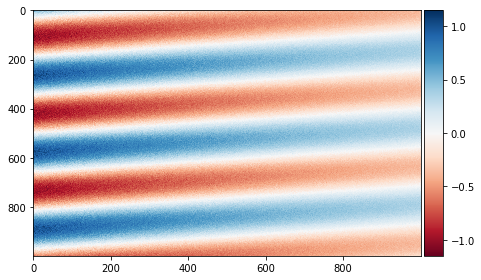

In [2]:
# The data we will try to approximate, a decaying, shifting sine wave

def f(t):
    N = 1000   # Number of states
    omega = 0.2
    decay_level = 0.1
    noise_level = 0.05
    x = np.linspace(-10,10,N)
    noise = noise_level*np.random.randn(N,len(t))
    decay = np.exp(-decay_level*t)
    return np.einsum('t,it->it', decay, np.sin(np.vstack(x) + omega*t) + noise)


t = np.linspace(0,10,1000)
dt = np.mean(np.diff(t))
data = f(t)
plot_data(data)


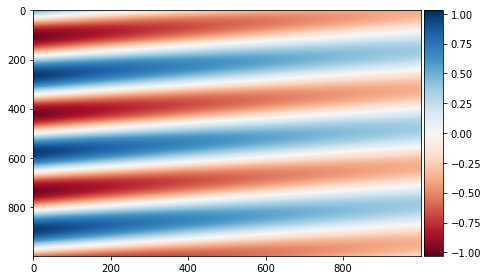

In [24]:
# The reference implementation, let it compute the optimum number of modes.
dmd = DMD(svd_rank=0, tlsq_rank=3)
dmd.fit(X=data)
plot_data(dmd.reconstructed_data)

Rank truncation:  15


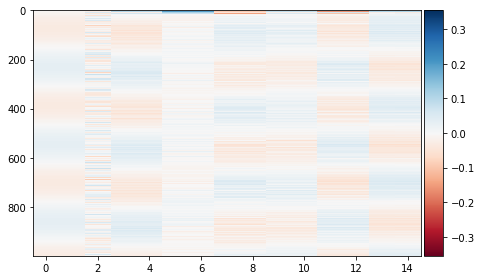

In [25]:
# Internal state
print("Rank truncation: ", dmd.atilde.shape[1])
plot_data(dmd.modes)

In [27]:
# Create the data matrices X and Y, where Y = AX (approx)
N = len(t)

X, Y = data[:,:-1], data[:,1:]
# X, Y = dmd._compute_tlsq(X, Y, 1)  # denoising step used in pyDMD

# Perform SVD on the data and 
U,S,V = np.linalg.svd(X, full_matrices=False)
V = V.conj().T  # This was killing me, why does numpy transpose this??

# Truncate to r dimensions
r = dmd.atilde.shape[1]
U_, S_, V_ = U[:,:r], S[:r], V[:,:r]

# Calculate the reduced dim A
A_ = U_.T.conj() @ Y @  V_ * np.reciprocal(S_) 

# Compute the DMD modes
L, W = np.linalg.eig(A_)
phi = U_ @ W   # These are the modes
# phi = Y @ (V_.T / np.vstack(S_)).T @ W  

# Eigenvalues of A_tilde 
omega = np.log(np.complex128(L))/dt  # complex128 because sometimes log returns negative real eigvals 

# Find the initial mode amplitudes
b, _, _, _ = np.linalg.lstsq(phi, X[:,0], rcond=None)

# Reconstruct the data
time_dynamics = np.exp(np.outer(omega, t)) * np.vstack(b)
reconstructed_ = phi @ time_dynamics

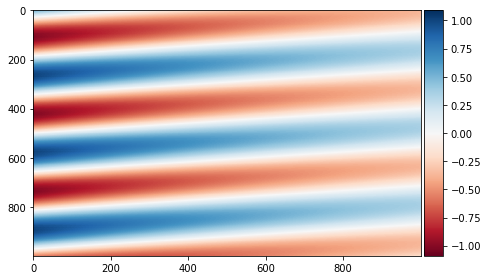

In [29]:
plot_data(reconstructed_)

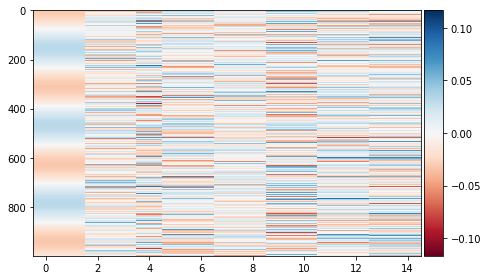

In [30]:
# Plot the modes
plot_data(phi)